# Derrivation
We'll derrive the first order equations of motion for an inverted pendulum on a cart, also known as a cartpole, using `sympy`.
We'll use the equations from [B. Srinivasan et al.](https://www.sciencedirect.com/science/article/pii/S0005109808004172)

In [1]:
from sympy import *
init_printing()

## State dynamics

Let's define the state symbols

In [2]:
p, v, theta, omega = symbols('p v \\theta \\omega')
s = Matrix([p, v, theta, omega])
s.T

[p  v  \theta  \omega]

Now let's define some constant parameters

In [3]:
# total mass, arm mass, arm length, intertia, gravity, arm inertia
m, mu, g, J = symbols('m \\mu g, J')

And finally, the control force input

In [4]:
u = symbols('u')

Let's put together the translational equations of motion

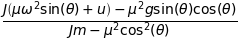

In [5]:
dp = v # velocity
dv = J*(u+mu*omega**2*sin(theta)) - mu**2*g*sin(theta)*cos(theta)
dv /= m*J-mu**2*cos(theta)**2
dv

And now the rotational equations of motion

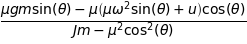

In [6]:
dtheta = omega
domega = m*mu*g*sin(theta)-mu*cos(theta)*(u+mu*omega**2*sin(theta))
domega /= m*J-mu**2*cos(theta)**2
domega

Now, let's put it all together in a system of ODEs in the form $\mathbf{f}(\pmb{s}, \pmb{u})$

In [7]:
ds = simplify(Matrix([dp, dv, dtheta, domega]))
ds

⎡                                v                                ⎤
⎢                                                                 ⎥
⎢                                          2                      ⎥
⎢       ⎛          2                ⎞   \mu ⋅g⋅sin(2⋅\theta)      ⎥
⎢     J⋅⎝\mu⋅\omega ⋅sin(\theta) + u⎠ - ────────────────────      ⎥
⎢                                                2                ⎥
⎢     ──────────────────────────────────────────────────────      ⎥
⎢                             2    2                              ⎥
⎢                    J⋅m - \mu ⋅cos (\theta)                      ⎥
⎢                                                                 ⎥
⎢                             \omega                              ⎥
⎢                                                                 ⎥
⎢    ⎛                  ⎛          2                ⎞            ⎞⎥
⎢\mu⋅⎝g⋅m⋅sin(\theta) - ⎝\mu⋅\omega ⋅sin(\theta) + u⎠⋅cos(\theta)⎠⎥
⎢───────────────────────────────────────────────

## Optimal control
Now, let's derrive the necessary components of Pontryagin's maximum principle.

First we need to define a dynamics cost function, known as the Lagrangian. Here, we'll also use a so called homotopy parameter to modulate the function.

In [8]:
alpha = symbols('\\alpha') # homotopy parameter
L = (1-alpha)*u**2 + alpha*u # Lagrangian
L

Next, we must define the so-called costate variables

In [9]:
l = Matrix([symbols('\\lambda_{}'.format(var)) for var in s])
l.T

[\lambdaₚ  \lambdaᵥ  \lambda_\theta  \lambda_\omega]

Now we have what we need to define the Hamiltonian
$H = \pmb{\lambda}^\intercal \pmb{f} + L$

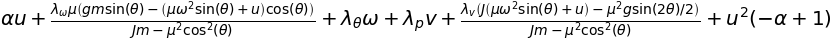

In [10]:
H = l.dot(ds) + L
collect(H, l)

A lá Pontryagin, the optimal control will maximise the Hamiltonian, so let's find $\text{argmax}_u(H)$

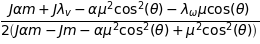

In [11]:
uo = simplify(solve(H.diff(u), u)[0])
uo

This is the optimal control. That wouldn't be very fun to solve for by hand!

## Normalised state dynamics
We can normalise the previous system with a new input and time scale to get nicer equations of motion.

In [12]:
# new state symbols and control
y, dy, theta, dtheta, v = symbols('y \\dot{y} \\theta \\dot{\\theta} v')
s = Matrix([y, dy, theta, dtheta]); s.T

[y  \dot{y}  \theta  \dot{\theta}]

In [13]:
# state dynamics
ds = Matrix([dy, v, dtheta, sin(theta) - v*cos(theta)])
ds.T

[\dot{y}  v  \dot{\theta}  -v⋅cos(\theta) + sin(\theta)]

Now we compute the Jacobian of the state dynamics:

In [14]:
dds = ds.jacobian(s); dds

⎡0  1               0               0⎤
⎢                                    ⎥
⎢0  0               0               0⎥
⎢                                    ⎥
⎢0  0               0               1⎥
⎢                                    ⎥
⎣0  0  v⋅sin(\theta) + cos(\theta)  0⎦

## Normalised optimal control

Now that we have the nondimensional equations of motion, we can again compute the optimal control.

First we redefine the Lagrangian:

In [15]:
alpha = symbols('\\alpha') # homotopy parameter
L = (1-alpha)*v**2 + alpha*v # Lagrangian
L

Then we again define the costate variables:

In [16]:
l = Matrix([symbols('\\lambda_{}'.format(var)) for var in s])
l.T

[\lambda_y  \lambda_\dot{y}  \lambda_\theta  \lambda_\dot{\theta}]

Then define the Hamiltonian again

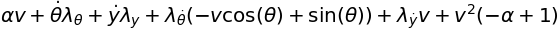

In [17]:
H = l.dot(ds) + L
collect(H, l)

And again, compute the optimal control alla moda di Pontryagin:

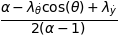

In [18]:
uo = solve(H.diff(v), v)[0]; simplify(uo)

To actually implement this, we need to compute the costate equations of motion:

In [19]:
dl = Matrix([-H.diff(var) for var in s]); simplify(dl)

⎡                         0                         ⎤
⎢                                                   ⎥
⎢                    -\lambda_y                     ⎥
⎢                                                   ⎥
⎢-\lambda_\dot{\theta}⋅(v⋅sin(\theta) + cos(\theta))⎥
⎢                                                   ⎥
⎣                  -\lambda_\theta                  ⎦

Now we can write the fullstate equations of motion

In [20]:
dfs = Matrix([ds, dl]); dfs

⎡                      \dot{y}                      ⎤
⎢                                                   ⎥
⎢                         v                         ⎥
⎢                                                   ⎥
⎢                   \dot{\theta}                    ⎥
⎢                                                   ⎥
⎢           -v⋅cos(\theta) + sin(\theta)            ⎥
⎢                                                   ⎥
⎢                         0                         ⎥
⎢                                                   ⎥
⎢                    -\lambda_y                     ⎥
⎢                                                   ⎥
⎢-\lambda_\dot{\theta}⋅(v⋅sin(\theta) + cos(\theta))⎥
⎢                                                   ⎥
⎣                  -\lambda_\theta                  ⎦

And compute the Jacobian:

In [21]:
fs = Matrix([s, l])
ddfs = dfs.jacobian(fs); simplify(ddfs)

⎡0  1                           0                           0  0   0  0       
⎢                                                                             
⎢0  0                           0                           0  0   0  0       
⎢                                                                             
⎢0  0                           0                           1  0   0  0       
⎢                                                                             
⎢0  0              v⋅sin(\theta) + cos(\theta)              0  0   0  0       
⎢                                                                             
⎢0  0                           0                           0  0   0  0       
⎢                                                                             
⎢0  0                           0                           0  -1  0  0       
⎢                                                                             
⎢0  0  \lambda_\dot{\theta}⋅(-v⋅cos(\theta) + sin(\t

In [23]:
L

In [ ]:
H